# [E-14] 인공지능으로 세상에 없던 새로운 패션 만들기

### 목차 

1. 라이브러리 Import 
2. 데이터 준비
3. 생성자 모델 구현
4. 판별자 모델 구현
5. 손실함수와 최적화함수 구현
6. 훈련과정 상세 기능 구현
7. 학습 진행
8. 성능향상
   

### 목표 

<br> 

|평가문항|상세기준|
|:---|:---|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. | 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2..생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.| gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3.  추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.| 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

<br>

### (1) 라이브러리 Import

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### (2\) 데이터 준비

In [2]:
# cifar10 dataset load 후 shape확인
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

In [3]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- 학습에 사용할 train_x 의 이미지를 [-1, 1] 로 정규화
- 데이터 시각화 

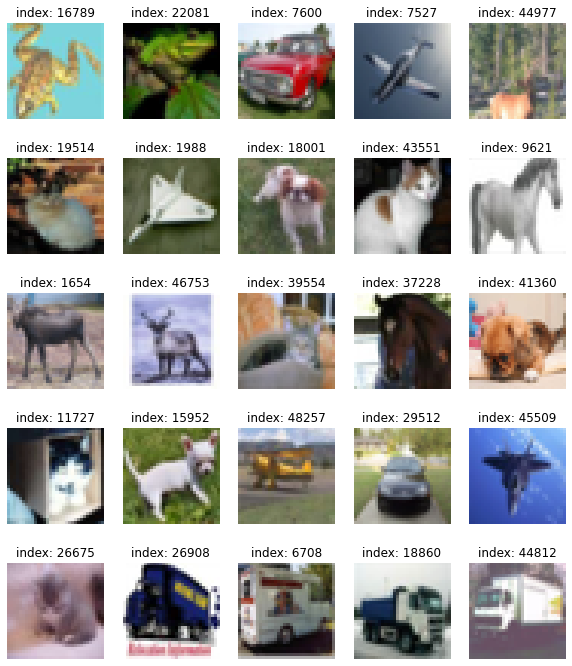

In [4]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

### (3) 생성자 모델 구현

In [5]:
def make_generator_model_one():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [6]:
generator_one = make_generator_model_one()

generator_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [7]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_one(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

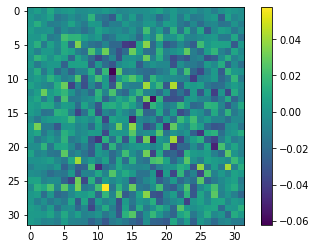

In [8]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### (4) 판별자 모델 구현

In [9]:
def make_discriminator_model_one():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [10]:
discriminator_one = make_discriminator_model_one()

discriminator_one.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### (5) 손실 함수와 최적화 함수 구현


- Real loss 는 1에 가까워져야 하고 fake loss 는 0 에 가까워져야 한다. total loss 는 두개의 loss 를 더해서 반환

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- 최적화 함수

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### (6) 훈련과정 상세 기능 구현



In [17]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [19]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig('/aiffel/aiffel/dcgan_newimage/fashion/generated_samples/EX01_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [21]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)

### (7) 학습진행


In [22]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [23]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

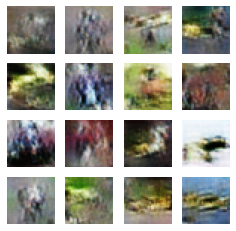

Time for training : 7239 sec


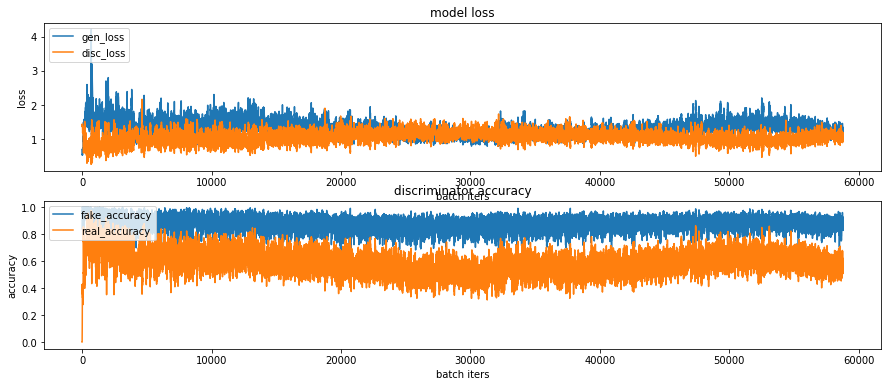

CPU times: user 2h 1min 30s, sys: 7min 51s, total: 2h 9min 21s
Wall time: 2h 43s


In [24]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [25]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 875619 Jun 21 09:48 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


### (8) 성능향상

- First attempt

In [26]:
def make_generator_model_two():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Reshape((8, 8, 128)))

    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))

    return model


In [27]:
generator_two = make_generator_model_two()

generator_two.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [28]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_two(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [29]:
def make_discriminator_model_two():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [30]:
discriminator_two = make_discriminator_model_two()

discriminator_two.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)         

In [31]:
save_every = 5
EPOCHS = 300

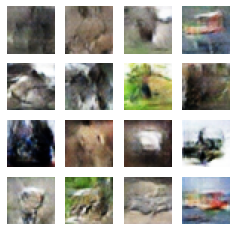

Time for training : 5238 sec


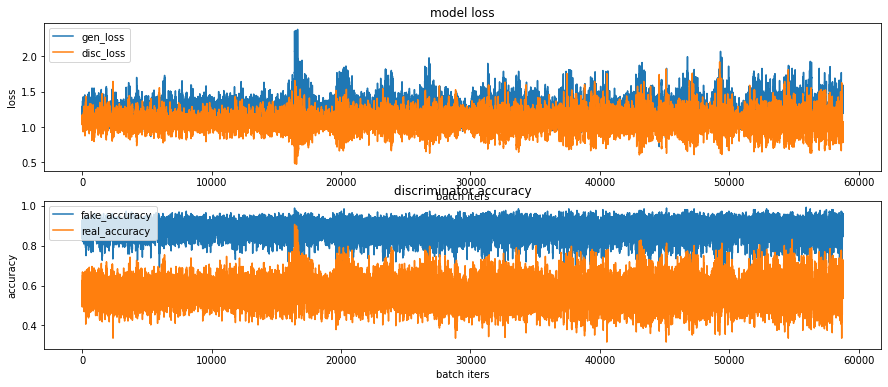

CPU times: user 1h 29min 17s, sys: 7min 54s, total: 1h 37min 11s
Wall time: 1h 27min 22s


In [32]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

- Second attempt

In [33]:
def make_generator_model_four():

    model = tf.keras.Sequential()

    # first: Dense layer
    model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # third: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # fifth: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # seventh: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # eigth: Conv2D layer                   
    model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))

    return model


In [34]:
generator_four = make_generator_model_four()

generator_four.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_12 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 128)        

In [35]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_four(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [36]:
def make_discriminator_model_four():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))


    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [37]:
discriminator_four = make_discriminator_model_four()

discriminator_four.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 128)      

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)

BUFFER_SIZE = 50000
BATCH_SIZE = 16

save_every = 5
EPOCHS = 100

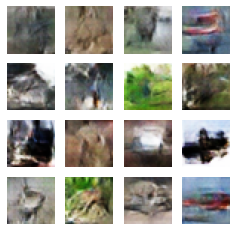

Time for training : 1646 sec


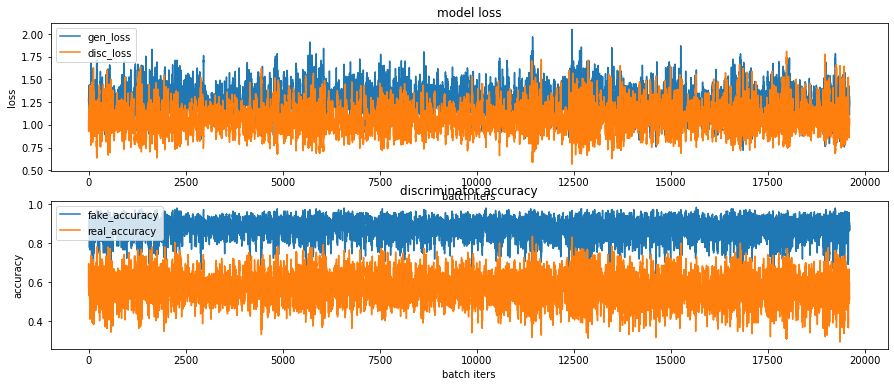

CPU times: user 28min 12s, sys: 2min 37s, total: 30min 49s
Wall time: 27min 27s


In [39]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)


# 회고

- GAN 의 두 모델 구조를 통해'오브젝트 종류를 육안으로 구별할 수 있을만한' 이미지를 생성하였고 GAN 학습이 바르게 진행되었음을 시각화 및 학습 그래프를 통해 확인하였다. 
- 추가적인 GAN 학습 과정 개선을 통해 성능이 향상 되었음을 시각화 그래프로 확인하였다. 

- 이번 과제도 Model 이 무거워서 에폭을 바꿔서 다양하게 해보고 싶었지만 학습시간이 너무 오래걸려서 아쉬웠다. 그래도 처음에는 이미지 형체가 많이 흐려 무슨 사진인지 알아보기 거의 불가능했으나 에포크 값을 높인 후 훨씬 선명해진 이미지를 확인할 수 있었다. 
- Exploration 노드 난이도가 올라감에 따라 시간도 비례하게 소요가 되는데 좀 더 시간적 여유가 있었다면 더 다양하게 시도해보고 더 좋은 결과를 얻을 수 있었을 것 같다. 